In [1]:
%load_ext dotenv
%reload_ext dotenv
%dotenv

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

In [4]:
import sys
import os
from os.path import dirname

UTILS_PATH=os.environ.get('REPO') + "/notebooks/commons"
sys.path.append(dirname(UTILS_PATH))

from commons import check_args, gen_paths
from commons import coordinates_bounds, plot_feature_importances
from commons import check_args_variables, gen_paths_variables

In [5]:
def load_posts(source_path, clean_path):
    external = pd.read_parquet(source_path)
    external.loc[:, "lat"] = external["lat"].apply(float)
    external.loc[:, "lon"] = external["lon"].apply(float)
    
    fincaraiz = pd.read_parquet(clean_path)
    return external, fincaraiz

In [6]:
if __name__ == "__main__":
    source = "PLACES"
    city = "manizales"
    
    property_type = "apartamentos"
    post_type = "arriendo"
    
    base_path = os.environ.get('REPO')
    
    source_path = base_path + gen_paths_variables(source, city)
    raw_path, clean_path = gen_paths(city, property_type, post_type)
        
    raw_path = base_path + raw_path
    clean_path = base_path + clean_path

In [7]:
external_variables, fincaraiz = load_posts(source_path, clean_path)

In [8]:
from math import cos, asin, sqrt
def distance(lat1, lon1, lat2, lon2):
    """
    El resultado de la medición de distancia esta en kilometros.
    """
    p = 0.017453292519943295     #Pi/180
    a = 0.5 - cos((lat2 - lat1) * p)/2 + cos(lat1 * p) * cos(lat2 * p) * (1 - cos((lon2 - lon1) * p)) / 2
    return 12742 * asin(sqrt(a))

def post_to_place_distance(publications, places, index):
    publication = publications.loc[index]
    
    places_to_point = places.copy()
    places_to_point.loc[:, "fid"] = publication["fid"]
    
    places_to_point.loc[:, "latitide"] = publication["latitude"]
    places_to_point.loc[:, "longitude"] = publication["longitude"]
    
    places_to_point.loc[:, "distance"] = places_to_point.apply(
        lambda e: distance(publication["latitude"], publication["longitude"], e["lat"], e["lon"]), axis=1)
        
    return places_to_point

import functools
from multiprocessing import Pool
def get_near_points(external_variables, fincaraiz):    
    distance_map = functools.partial(
        post_to_place_distance, 
        fincaraiz, external_variables)
    
    pool = Pool(8)
    distances = pool.map(
        distance_map,
        fincaraiz.index
    )

    return pd.concat(distances).reset_index(drop=True)

In [9]:
distances_map = get_near_points(external_variables, fincaraiz)
distances_map.head()

,lat,lon,amenity,name,fid,latitide,longitude,distance
0,5.045668,-75.528992,university,Universidad Antonio Nariño Manizales,5469476,5.058869,-75.475807,6.070991
1,5.045668,-75.528992,university,UAN Universidad Antonio Nariño,5469476,5.058869,-75.475807,6.070991
2,5.001526,-75.598802,university,Mànizales,5469476,5.058869,-75.475807,15.042040
3,4.985796,-75.606928,university,CUN - Corporación Unificada Nacional de Educac...,5469476,5.058869,-75.475807,16.642402
4,4.983539,-75.605624,university,JUZGADO PRIMERO PROMISCUO MUNICIPAL DE CHINCHINÁ,5469476,5.058869,-75.475807,16.641444


In [10]:
distances_map.loc[distances_map["distance"] == distances_map["distance"].min()]

,lat,lon,amenity,name,fid,latitide,longitude,distance
10768,5.070275,-75.513817,university,Yerly natalia López Acevedo,5174681,5.070275,-75.513817,0.0
10769,5.070275,-75.513817,university,Colegio de Jueces y Fiscales de Caldas,5174681,5.070275,-75.513817,0.0
10798,5.070275,-75.513817,shopping_mall,Auditorio unicentro estrella,5174681,5.070275,-75.513817,0.0
10799,5.070275,-75.513817,shopping_mall,El cable plaza,5174681,5.070275,-75.513817,0.0
10800,5.070275,-75.513817,shopping_mall,Ley sancancio,5174681,5.070275,-75.513817,0.0
...,...,...,...,...,...,...,...,...
2371109,5.062974,-75.502770,local_government_office,TRANSPORTES MCS,5696035,5.062974,-75.502769,0.0
2371348,5.062974,-75.502770,church,Iglesia Cristiana Vida Church,5696035,5.062974,-75.502769,0.0
2372370,5.062974,-75.502770,school,Ceder,5696035,5.062974,-75.502769,0.0
2372371,5.062974,-75.502770,school,Mandala Taller Creativo,5696035,5.062974,-75.502769,0.0


In [11]:
## Un punto de interes es cercano a la publicicación cuando esta a menos de 3 kilometros

near_points = distances_map.loc[distances_map["distance"] < 3]
near_points.head()

,lat,lon,amenity,name,fid,latitide,longitude,distance
411,5.038010,-75.491961,university,Academía Nacional de Aviación ANAV,5469476,5.058869,-75.475807,2.929344
418,5.054574,-75.495624,university,Colegio Comercial,5469476,5.058869,-75.475807,2.246317
419,5.054832,-75.495770,university,Edificio Bicentenario,5469476,5.058869,-75.475807,2.256242
420,5.054685,-75.495517,university,Sede Micaela U. De Caldas,5469476,5.058869,-75.475807,2.232149
421,5.059320,-75.497738,school,Colegio San Luis Gonzaga,5469476,5.058869,-75.475807,2.429622


In [12]:
near_points.describe()

,lat,lon,latitide,longitude,distance
count,1.344596e+06,1.344596e+06,1.344596e+06,1.344596e+06,1.344596e+06
mean,5.060098e+00,-7.549880e+01,5.059409e+00,-7.549689e+01,1.648250e+00
std,1.019247e-02,1.506732e-02,9.161282e-03,1.429846e-02,7.851937e-01
min,5.006339e+00,-7.556583e+01,5.018835e+00,-7.554790e+01,0.000000e+00
25%,5.053547e+00,-7.551173e+01,5.052409e+00,-7.550755e+01,1.008941e+00
50%,5.061704e+00,-7.549765e+01,5.060936e+00,-7.549421e+01,1.655485e+00
75%,5.067250e+00,-7.548775e+01,5.065499e+00,-7.548565e+01,2.322002e+00
max,5.110130e+00,-7.542641e+01,5.109370e+00,-7.544830e+01,2.999997e+00


In [13]:
near_points_by_categories = near_points[["fid", "amenity", "name"]].groupby(["fid", "amenity"]).count()
near_points_by_categories.head()

name
fid     amenity             
2450401 amusement_park     1
        bank             111
        church            72
        hospital          59
        library           13

In [14]:
index = list(zip(*near_points_by_categories.index))
near_points_by_categories.loc[:, "fid"] = index[0]
near_points_by_categories.loc[:, "amenity"] = index[1]
near_points_by_categories.loc[:, "count"] = near_points_by_categories["name"]

near_points_by_categories = near_points_by_categories.reset_index(drop=True)
near_points_by_categories = near_points_by_categories.drop(["name"], axis=1)
near_points_by_categories.head()

,fid,amenity,count
0,2450401,amusement_park,1
1,2450401,bank,111
2,2450401,church,72
3,2450401,hospital,59
4,2450401,library,13


In [15]:
posts_full = fincaraiz[["fid"]].copy()
posts_full = posts_full.drop_duplicates(["fid"])

def safe_get(post, amenity):
    client = near_points_by_categories.loc[
        near_points_by_categories["fid"] == post["fid"]]
    
    if client.shape[0] == 0:
        return 0
    
    client = client.loc[client["amenity"] == amenity]
    if client.shape[0] == 0:
        return 0
    
    return client["count"].iloc[0]

In [16]:
for amenity in external_variables["amenity"].value_counts().index:
    posts_full.loc[:, amenity] = posts_full.apply(lambda e: safe_get(e, amenity), axis=1)

In [17]:
posts_full["airport"].describe()

count    1027.000000
mean        0.198637
std         0.399168
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: airport, dtype: float64

In [18]:
## Las features y las etiquetas son las mismas en todos los métodos

FEATURES = list(filter(lambda e: e != "fid", posts_full.columns))
LABEL = "price"

final_features = pd.merge(posts_full, fincaraiz[["fid", "price"]], on="fid")

X = final_features[FEATURES].values
y = final_features[LABEL].values

## Selección de features univariada

In [19]:
selector = SelectKBest(f_regression, k=5)
X_new = selector.fit_transform(X, y)
X_new.shape

(1027, 5)

In [20]:
feature_importances = pd.DataFrame({'importance': selector.scores_, 'feature': FEATURES})

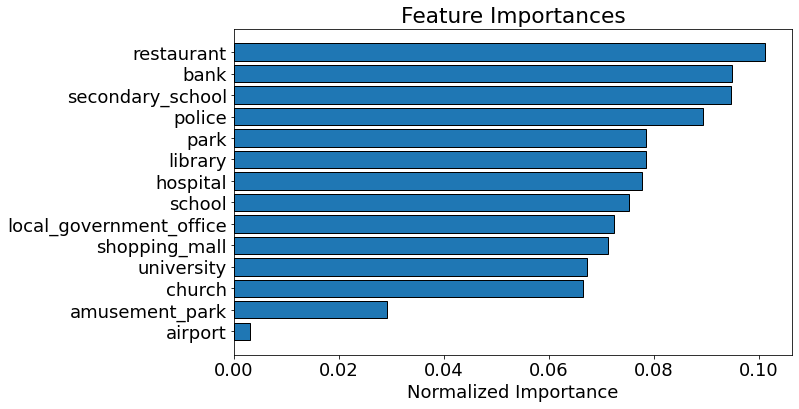

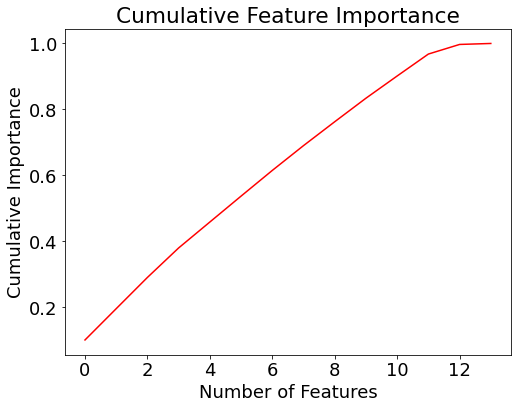

11 features required for 0.90 of cumulative importance


,index,importance,feature,importance_normalized,cumulative_importance
0,0,2.239681,restaurant,0.101289,0.101289
1,2,2.097934,bank,0.094879,0.196168
2,10,2.093976,secondary_school,0.094700,0.290868
3,9,1.976089,police,0.089368,0.380236
4,4,1.737609,park,0.078583,0.458819
5,11,1.736512,library,0.078533,0.537352
6,6,1.720601,hospital,0.077814,0.615166
7,1,1.663051,school,0.075211,0.690377
8,8,1.600796,local_government_office,0.072396,0.762773
9,5,1.576775,shopping_mall,0.071309,0.834082


In [21]:
plot_feature_importances(feature_importances)

## Eliminación recursiva de features

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

In [23]:
reg = LinearRegression().fit(X, y)
reg.score(X, y)

0.0066907921890383415

In [24]:
rfe = RFE(estimator=reg, n_features_to_select=1, step=1)
rfe.fit(X, y)

RFE(estimator=LinearRegression(), n_features_to_select=1)

In [25]:
feature_importances = pd.DataFrame({'importance': rfe.ranking_, 'feature': FEATURES})

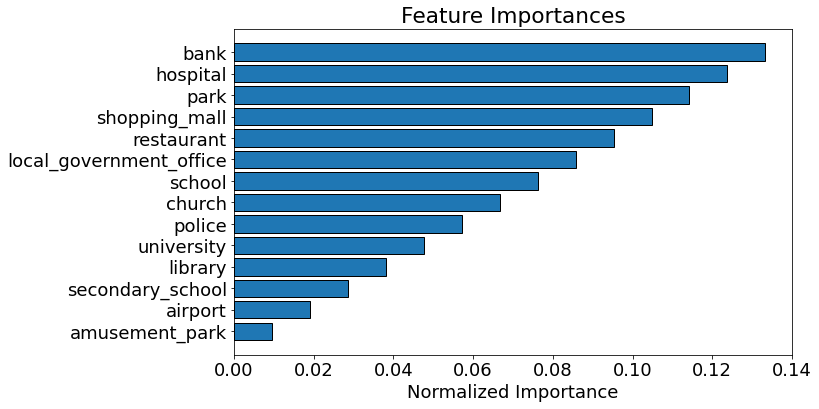

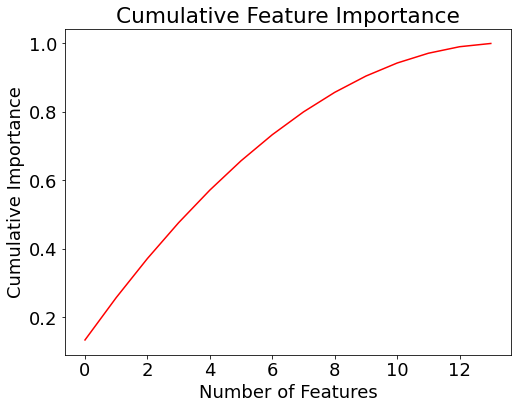

10 features required for 0.90 of cumulative importance


,index,importance,feature,importance_normalized,cumulative_importance
0,2,14,bank,0.133333,0.133333
1,6,13,hospital,0.123810,0.257143
2,4,12,park,0.114286,0.371429
3,5,11,shopping_mall,0.104762,0.476190
4,0,10,restaurant,0.095238,0.571429
5,8,9,local_government_office,0.085714,0.657143
6,1,8,school,0.076190,0.733333
7,3,7,church,0.066667,0.800000
8,9,6,police,0.057143,0.857143
9,7,5,university,0.047619,0.904762


In [26]:
plot_feature_importances(feature_importances)

## Selección de features basada en arboles

In [27]:
from sklearn.ensemble import ExtraTreesRegressor

In [28]:
forest = ExtraTreesRegressor(n_estimators=100, random_state=0)
forest.fit(X, y)

ExtraTreesRegressor(random_state=0)

In [29]:
feature_importances = pd.DataFrame({'importance':  forest.feature_importances_, 'feature': FEATURES})

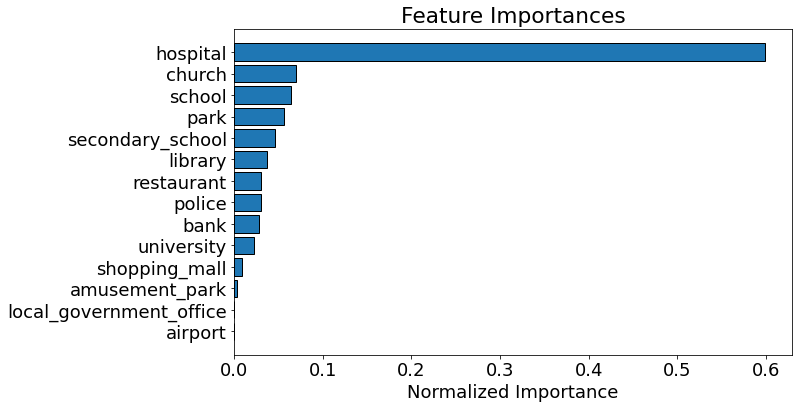

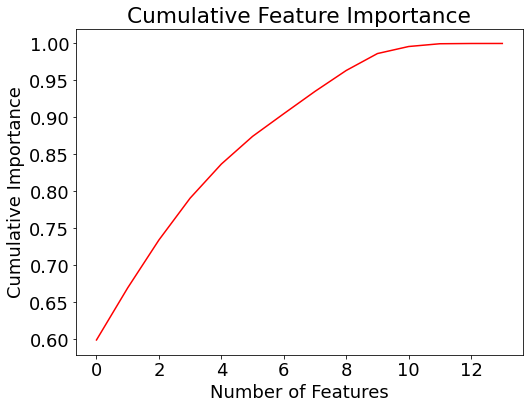

7 features required for 0.90 of cumulative importance


,index,importance,feature,importance_normalized,cumulative_importance
0,6,0.599075,hospital,0.599075,0.599075
1,3,0.070483,church,0.070483,0.669558
2,1,0.064732,school,0.064732,0.734291
3,4,0.056584,park,0.056584,0.790874
4,10,0.046072,secondary_school,0.046072,0.836947
5,11,0.037434,library,0.037434,0.874381
6,0,0.030656,restaurant,0.030656,0.905038
7,9,0.030180,police,0.030180,0.935218
8,2,0.028255,bank,0.028255,0.963473
9,7,0.022884,university,0.022884,0.986357


In [30]:
plot_feature_importances(feature_importances)